# Validation of integrating isotope incorporation into BD KDE

* E coli
* Trying differing amounts of incorporation
* Comparing resulting BD KDEs

# Setting variables

In [1]:
workDir = '/home/nick/notebook/SIPSim/dev/Ecoli/'
genomeDir = '/home/nick/notebook/SIPSim/dev/Ecoli/genomes/'

# Init

In [79]:
import glob
import nestly
from IPython.display import Image, display, HTML

In [2]:
%load_ext rpy2.ipython
%matplotlib inline

In [3]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid


# Setting up nestly

In [64]:
# building tree structure
nest = nestly.Nest()

## varying params
nest.add('percIncorp', range(0,101,20))

## set params
nest.add('np', [24], create_dir=False)
nest.add('percTaxa', [100], create_dir=False)

## input/output files
nest.add('fileName', ['ampFrags'], create_dir=False)
nest.add('genome_index', [os.path.join(genomeDir, 'genome_index.txt')], create_dir=False)
nest.add('genome_dir', [genomeDir], create_dir=False)
nest.add('primers', [os.path.join(workDir, '../', '515F-806R.fna')], create_dir=False)

# building directory tree
buildDir = os.path.join(workDir, 'incorp')
nest.build(buildDir)

In [65]:
bashFile = os.path.join(workDir, 'SIPSimRun.sh')

In [66]:
%%writefile $bashFile
#!/bin/bash

# simulating fragments
SIPSim fragments \
    {genome_index} \
    --fp {genome_dir} \
    --fr {primers} \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np {np} \
    2> {fileName}.log \
    > {fileName}.pkl
    
# converting to kde object
SIPSim fragment_kde \
    {fileName}.pkl \
    > {fileName}_kde.pkl    

# plotting  
SIPSim KDE_plot \
    {fileName}_kde.pkl  \
    --xMin 1.66 --xMax 1.8 \
    -o {fileName}_kde.png  
SIPSim KDE_plot \
    {fileName}_kde.pkl  \
    --xMin 1.66 --xMax 1.8 --logY 10 \
    -o {fileName}_kde_log10.png      
    
# adding diffusion
SIPSim diffusion \
    {fileName}_kde.pkl \
    --np {np} \
    > {fileName}_kde_dif.pkl

# plotting  
SIPSim KDE_plot \
    {fileName}_kde_dif.pkl  \
    --xMin 1.66 --xMax 1.8 \
    -o {fileName}_kde_dif.png  
SIPSim KDE_plot \
    {fileName}_kde_dif.pkl  \
    --xMin 1.66 --xMax 1.8 --logY 10 \
    -o {fileName}_kde_dif_log10.png         
    
# making incorp file
SIPSim incorpConfigExample \
  --percTaxa {percTaxa} \
  --percIncorpUnif {percIncorp} \
  > {percTaxa}_{percIncorp}.config
    
# adding isotope incorporation to BD distribution
SIPSim isoIncorp \
    {fileName}_kde_dif.pkl \
    {percTaxa}_{percIncorp}.config \
    --np {np} \
    > {fileName}_kde_dif_incorp.pkl
    
# plotting  
SIPSim KDE_plot \
    {fileName}_kde_dif_incorp.pkl \
    --xMin 1.66 --xMax 1.8 \
    -o {fileName}_kde_dif_incorp.png
SIPSim KDE_plot \
    {fileName}_kde_dif_incorp.pkl \
    --xMin 1.66 --xMax 1.8 --logY 10 \
    -o {fileName}_kde_dif_incorp_log10.png
    
# BD shift
SIPSim BD_shift \
    {fileName}_kde_dif.pkl \
    {fileName}_kde_dif_incorp.pkl \
    > {fileName}_BD-shift.txt 

Overwriting /home/nick/notebook/SIPSim/dev/Ecoli/SIPSimRun.sh


In [67]:
!chmod 775 $bashFile

In [68]:
!cd $workDir; \
    nestrun -j 1 --template-file $bashFile -d incorp --log-file log.txt

2015-07-13 13:15:56,960 * INFO * Template: ./SIPSimRun.sh
2015-07-13 13:15:56,962 * INFO * [105952] Started ./SIPSimRun.sh in incorp/80
2015-07-13 13:16:36,845 * INFO * [105952] incorp/80 Finished with 0
2015-07-13 13:16:36,849 * INFO * [106275] Started ./SIPSimRun.sh in incorp/20
2015-07-13 13:17:17,104 * INFO * [106275] incorp/20 Finished with 0
2015-07-13 13:17:17,108 * INFO * [106562] Started ./SIPSimRun.sh in incorp/0
2015-07-13 13:17:58,134 * INFO * [106562] incorp/0 Finished with 0
2015-07-13 13:17:58,138 * INFO * [106845] Started ./SIPSimRun.sh in incorp/60
2015-07-13 13:18:39,801 * INFO * [106845] incorp/60 Finished with 0
2015-07-13 13:18:39,805 * INFO * [107162] Started ./SIPSimRun.sh in incorp/100
2015-07-13 13:19:21,476 * INFO * [107162] incorp/100 Finished with 0
2015-07-13 13:19:21,480 * INFO * [107446] Started ./SIPSimRun.sh in incorp/40
2015-07-13 13:20:03,668 * INFO * [107446] incorp/40 Finished with 0


# Loading images

## Images of iso incorp

/home/nick/notebook/SIPSim/dev/Ecoli/incorp/0/ampFrags_kde_dif_incorp_1.png


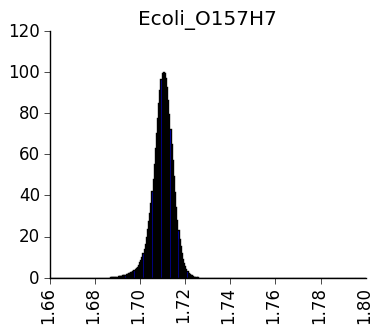

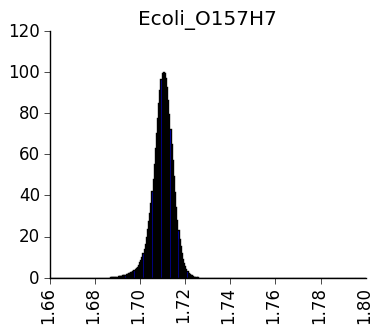

/home/nick/notebook/SIPSim/dev/Ecoli/incorp/100/ampFrags_kde_dif_incorp_1.png


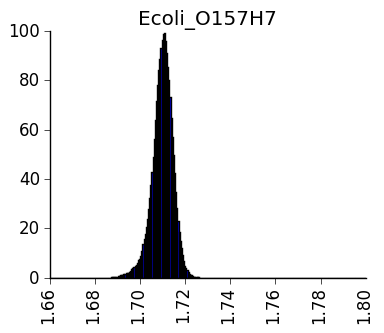

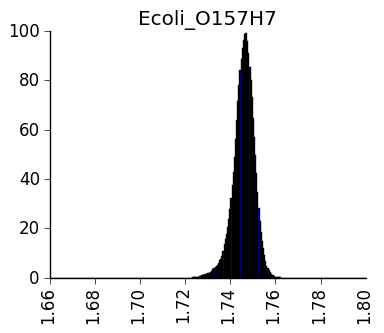

/home/nick/notebook/SIPSim/dev/Ecoli/incorp/20/ampFrags_kde_dif_incorp_1.png


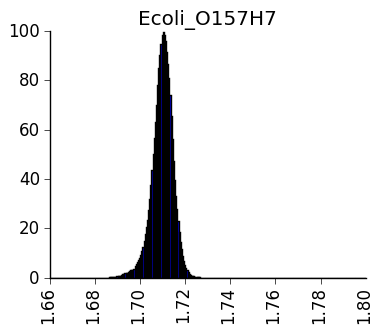

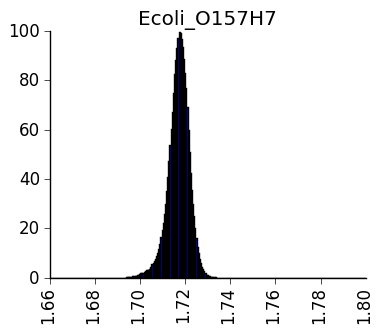

/home/nick/notebook/SIPSim/dev/Ecoli/incorp/40/ampFrags_kde_dif_incorp_1.png


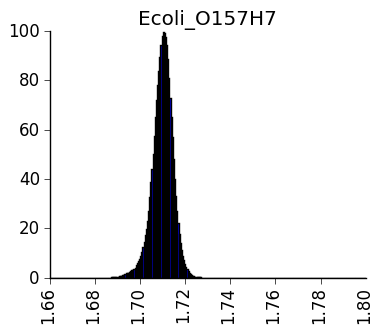

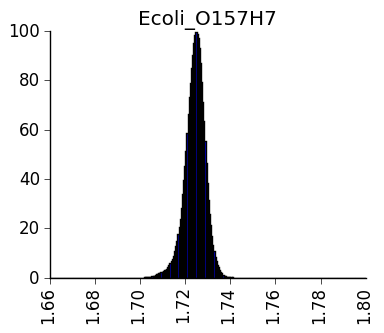

/home/nick/notebook/SIPSim/dev/Ecoli/incorp/60/ampFrags_kde_dif_incorp_1.png


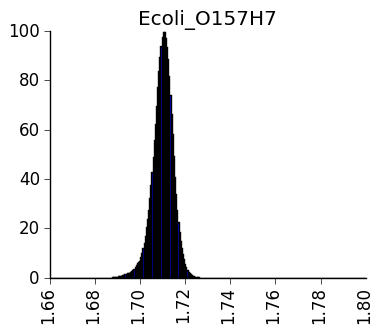

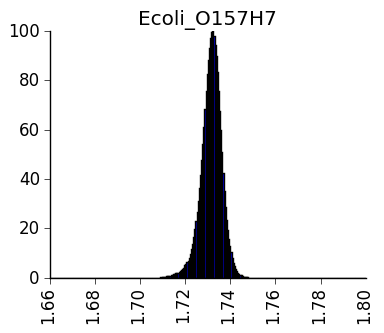

/home/nick/notebook/SIPSim/dev/Ecoli/incorp/80/ampFrags_kde_dif_incorp_1.png


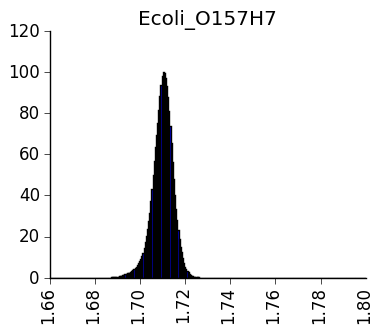

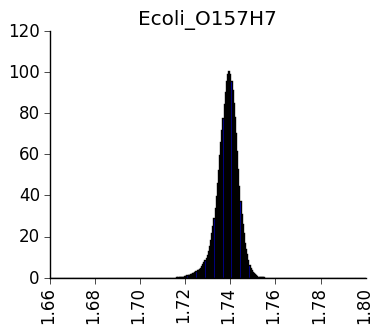

In [112]:
tmpDir = os.path.join(workDir, 'incorp')
incorp_L1 = glob.glob(os.path.join(tmpDir, '*/*incorp_1.png'))
incorp_L2 = glob.glob(os.path.join(tmpDir, '*/*incorp_2.png'))

for L1,L2 in zip(sorted(incorp_L1), sorted(incorp_L2)):
    print L1
    img1 = Image(L1, retina=True)
    img2 = Image(L2, retina=True)    
    display(img1, img2)

/home/nick/notebook/SIPSim/dev/Ecoli/incorp/0/ampFrags_kde_dif_incorp_log10_1.png


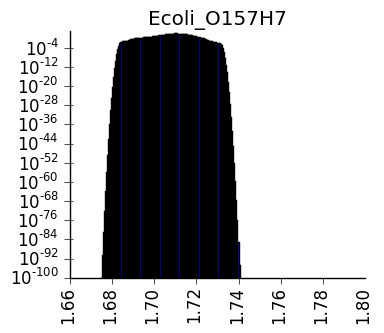

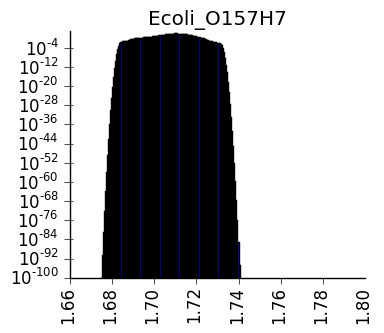

/home/nick/notebook/SIPSim/dev/Ecoli/incorp/100/ampFrags_kde_dif_incorp_log10_1.png


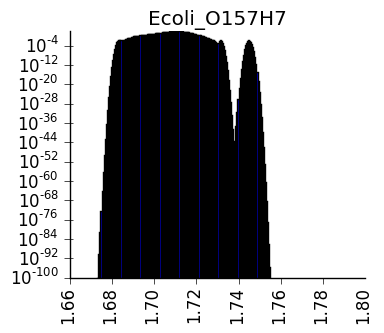

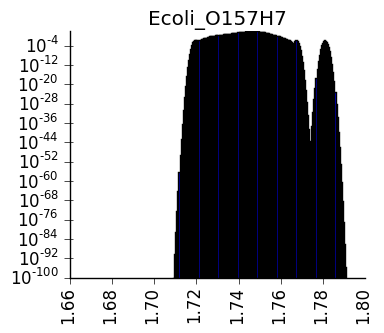

/home/nick/notebook/SIPSim/dev/Ecoli/incorp/20/ampFrags_kde_dif_incorp_log10_1.png


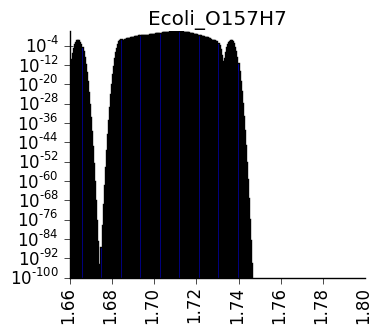

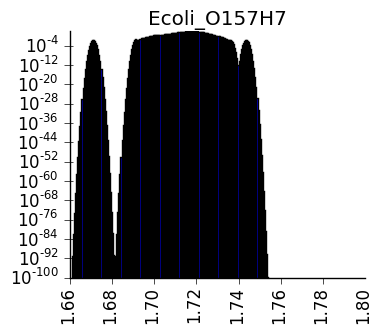

/home/nick/notebook/SIPSim/dev/Ecoli/incorp/40/ampFrags_kde_dif_incorp_log10_1.png


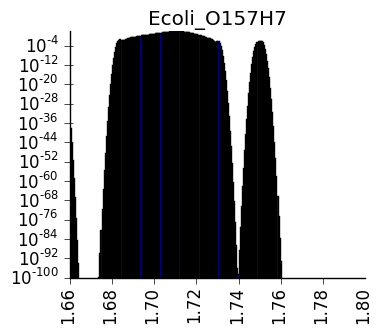

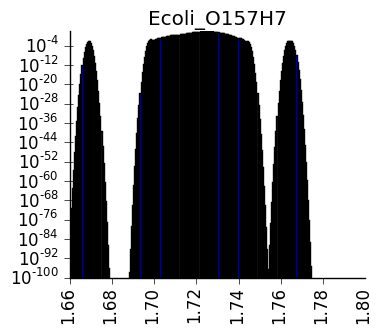

/home/nick/notebook/SIPSim/dev/Ecoli/incorp/60/ampFrags_kde_dif_incorp_log10_1.png


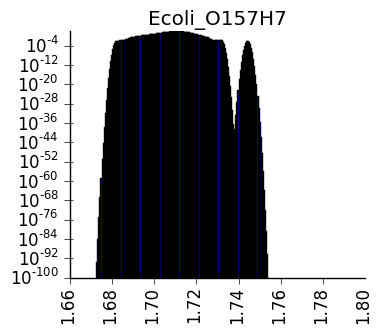

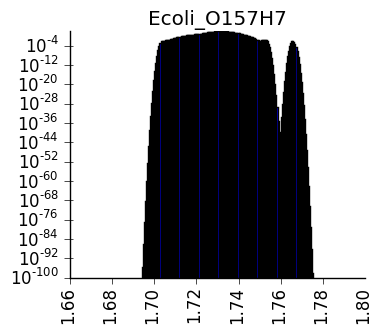

/home/nick/notebook/SIPSim/dev/Ecoli/incorp/80/ampFrags_kde_dif_incorp_log10_1.png


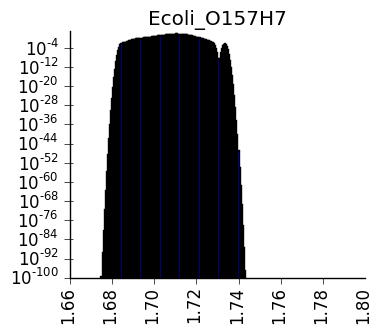

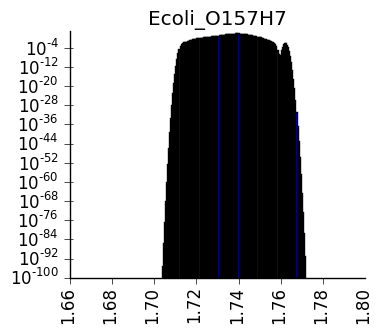

In [113]:
# log10
tmpDir = os.path.join(workDir, 'incorp')
incorp_L1 = glob.glob(os.path.join(tmpDir, '*/*incorp_log10_1.png'))
incorp_L2 = glob.glob(os.path.join(tmpDir, '*/*incorp_log10_2.png'))

for L1,L2 in zip(sorted(incorp_L1), sorted(incorp_L2)):
    print L1
    img1 = Image(L1, retina=True)
    img2 = Image(L2, retina=True)    
    display(img1, img2)

***

# Sandbox

In [102]:
tmpDir = os.path.join(workDir, 'incorp')
incorp_L1 = glob.glob(os.path.join(tmpDir, '*/*incorp_1.png'))
incorp_L2 = glob.glob(os.path.join(tmpDir, '*/*incorp_2.png'))

s = """<table>
<tr>
<th><img src="{}"/></th>
<th><img src="{}"/></th>
</tr></table>"""

for L1,L2 in zip(sorted(incorp_L1), sorted(incorp_L2)):
    s = s.format(str(L1), str(L2))
    print(s)
    t = HTML(s)
    display(t)

<table>
<tr>
<th><img src="/home/nick/notebook/SIPSim/dev/Ecoli/incorp/0/ampFrags_kde_dif_incorp_1.png"/></th>
<th><img src="/home/nick/notebook/SIPSim/dev/Ecoli/incorp/0/ampFrags_kde_dif_incorp_2.png"/></th>
</tr></table>


,


<table>
<tr>
<th><img src="/home/nick/notebook/SIPSim/dev/Ecoli/incorp/0/ampFrags_kde_dif_incorp_1.png"/></th>
<th><img src="/home/nick/notebook/SIPSim/dev/Ecoli/incorp/0/ampFrags_kde_dif_incorp_2.png"/></th>
</tr></table>


,


<table>
<tr>
<th><img src="/home/nick/notebook/SIPSim/dev/Ecoli/incorp/0/ampFrags_kde_dif_incorp_1.png"/></th>
<th><img src="/home/nick/notebook/SIPSim/dev/Ecoli/incorp/0/ampFrags_kde_dif_incorp_2.png"/></th>
</tr></table>


,


<table>
<tr>
<th><img src="/home/nick/notebook/SIPSim/dev/Ecoli/incorp/0/ampFrags_kde_dif_incorp_1.png"/></th>
<th><img src="/home/nick/notebook/SIPSim/dev/Ecoli/incorp/0/ampFrags_kde_dif_incorp_2.png"/></th>
</tr></table>


,


<table>
<tr>
<th><img src="/home/nick/notebook/SIPSim/dev/Ecoli/incorp/0/ampFrags_kde_dif_incorp_1.png"/></th>
<th><img src="/home/nick/notebook/SIPSim/dev/Ecoli/incorp/0/ampFrags_kde_dif_incorp_2.png"/></th>
</tr></table>


,


<table>
<tr>
<th><img src="/home/nick/notebook/SIPSim/dev/Ecoli/incorp/0/ampFrags_kde_dif_incorp_1.png"/></th>
<th><img src="/home/nick/notebook/SIPSim/dev/Ecoli/incorp/0/ampFrags_kde_dif_incorp_2.png"/></th>
</tr></table>


,
